<a href="https://colab.research.google.com/github/Muhammad-BILAL-5/supervisor-agents/blob/main/Supervisor_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade -U langchain langchain_community langgraph langchain-groq langchain_experimental langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import os

os.environ["TAVILY_API_KEY"] = userdata.get("tavily_api_key")
os.environ["GOOGLE_API_KEY"] = userdata.get("Gemini_Api_Key")
os.environ["LANGCHAIN_API_KEY"] = userdata.get("langchai_api_key")

In [ ]:
from langchain.agents import AgentExecutor , create_tool_calling_agent
from langchain.prompts import MessagesPlaceholder
from langchain.prompts import ChatPromptTemplate
from langchain.schema import HumanMessage

#creating agent
def create_agent(llm , tools: list , system_message: str):
  prompt = ChatPromptTemplate.from_messages([
      ("system", system_message),
      MessagesPlaceholder(variable_name="messages"),
      MessagesPlaceholder(variable_name="agent_scratchpad"),
  ])

  agent = create_tool_calling_agent(
      llm=llm,
      tools=tools,
      prompt=prompt,
  )
  agent_executor = AgentExecutor(agent=agent,tools = tools)
  return agent_executor

In [ ]:
from langchain_community.tools import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily = TavilySearchResults()

python_repl = PythonREPLTool()

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [ ]:
import functools

#define agent node
def agent_node(state , agent , name):
  user_query = state["messages"][0].content # Assuming the first message is the user's query.
  # Create a new input dictionary with the query
  input_with_query = {"query": user_query}
  result = agent.invoke(input_with_query)
  result["name"] =name
  return { "messages": [HumanMessage(content=result["output"] , name = name)]}

#tavily agent node
tavily_agent = create_agent(llm,[tavily], "you are helpfull agent , answer the user's queries carefully")
tavily_node = functools.partial(agent_node , agent = tavily_agent , name = "tavily_search")


#python agent node
python_agent = create_agent(llm,[python_repl], "you are helpfull agent , answer the user's queries carefully")
python_node = functools.partial(agent_node , agent = python_agent , name = "python_repl")

In [ ]:
members = ["tavily_search" , "python_repl"]

template = (
    "You are a supervisor , tasked with managing conversation between"
    "following workers:{members}. Given the following user request,"
    "respond with workers to act next.Each worker perform a task and"
    "respond with their results and status . When finished,"
    "respond with FINISH."
)

options = ["FINISH"] + members

prompt = ChatPromptTemplate.from_messages(
    [
        ("system" , template+"Given the conversation above, who should act next? Or Should we FINISH?.Select one of:{options}"),
        MessagesPlaceholder(variable_name="messages"),
    ]
).partial(options = str(options) , members = ", ".join(members))


# Instead of using JsonOutputFunctionsParser, use a custom output parser.
def custom_output_parser(text: str) -> dict:
    """Parses the output text to extract the 'next' worker."""
    # Assuming the model outputs the worker name directly.
    # You might need to adjust this based on your model's actual output.
    next_worker = text.content.strip()
    if next_worker in options:
        return {"next": next_worker}
    else:
        # Handle cases where the model outputs an invalid worker.
        # For example, you could default to "FINISH" or raise an exception.
        return {"next": "FINISH"}

sepurvisor_chain = prompt | llm | custom_output_parser

In [ ]:
from typing import TypedDict, Annotated , List , Sequence
from langchain.schema import BaseMessage
import operator

#define agent state
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage] , operator.add]
  next:str

In [ ]:
#define graphstate
from langgraph.graph import StateGraph , END

graph = StateGraph(AgentState)

graph.add_node("tavily_search" , tavily_node)
graph.add_node("python_repl" , python_node)
graph.add_node("Supervisor" , sepurvisor_chain)

for member in members:
  graph.add_edge(member , "Supervisor" )

conditional_map = {k:k for k in members}
conditional_map["FINISH"] = END
graph.add_conditional_edges("Supervisor", lambda x:x["next"] , conditional_map)

graph.set_entry_point("Supervisor")

app = graph.compile()

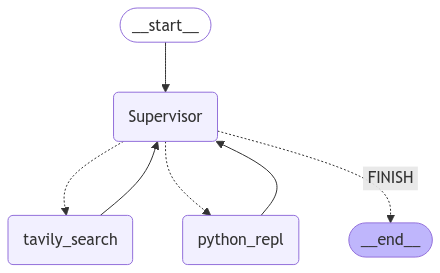

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
input = {"messages": [HumanMessage(content="give me a roadmap to learn langchain?")]}

for output in app.stream(input):
  for key,value in output.items():
    print(f"Getting response from {key}")
    print(value)
    print("----")

Getting response from Supervisor
{'next': 'tavily_search'}
----
Getting response from tavily_search
{'messages': [HumanMessage(content="Here's a roadmap to learn LangChain:\n\n**1. Foundational Knowledge:**\n\n* **Python:**  A strong Python foundation is essential. Focus on data structures (lists, dictionaries), classes, and object-oriented programming concepts.\n* **APIs and Libraries:** Familiarize yourself with working with APIs and libraries like `requests`.  This will be crucial for interacting with external services and models.\n\n**2. Core LangChain Concepts:**\n\n* **LLMs and Prompts:** Understand how to interact with large language models (LLMs) and the importance of prompt engineering. Experiment with different prompting techniques to achieve desired outputs.\n* **Chains:** Learn how to create chains to orchestrate sequences of calls to LLMs or other utilities. This is a fundamental concept in LangChain.\n* **Indexes:**  Understand how to structure your data for use with LLMs